In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime
from datetime import timedelta
from time import time
from pandas.plotting import register_matplotlib_converters

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [4]:
production_ice_cream = pd.read_csv('./data/ice_cream.csv',
                                   parse_dates=[0],
                                   index_col=0,
                                   squeeze=True,
                                   date_parser=parser)

In [5]:
# this now becomes a series

production_ice_cream.rename('production', inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [6]:
# infer the frequency of the data
production_ice_cream = production_ice_cream.asfreq(
    pd.infer_freq(production_ice_cream.index)
)
production_ice_cream

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 577, dtype: float64

In [7]:
# get dates from 2010

start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

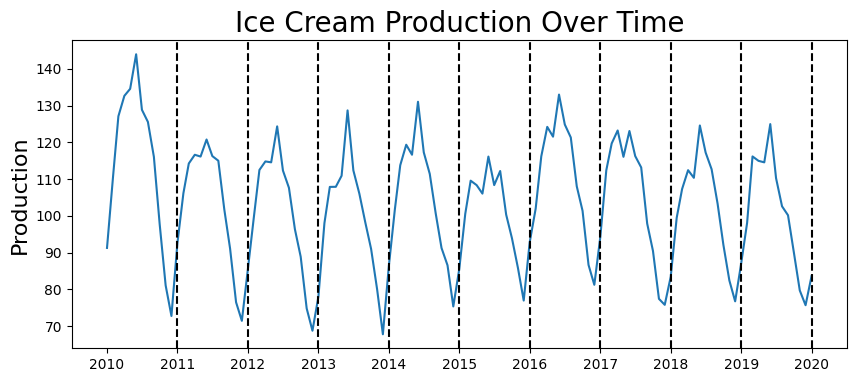

In [8]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production Over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--')

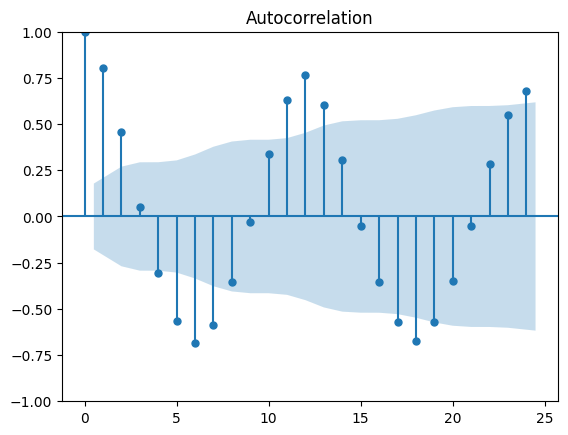

In [9]:
acf_plot = plot_acf(production_ice_cream, lags=24)

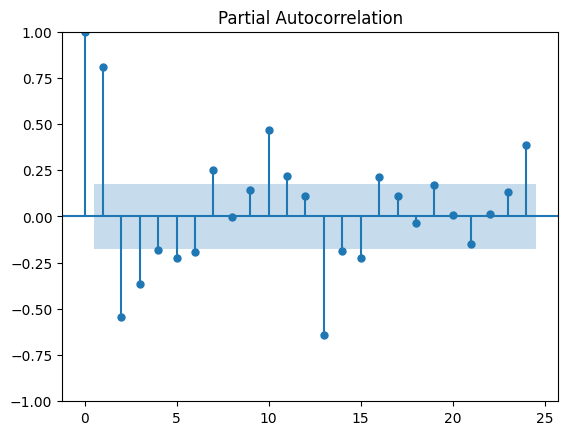

In [10]:
pacf_plot = plot_pacf(production_ice_cream, lags=24)

# Fitting The Model

## Get training and testing sets

In [11]:
train_end = datetime(2018, 12, 1)
test_end = datetime(2019, 12, 1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[
    train_end + timedelta(days=1):test_end]


## ARIMA [3, 0, 0]

In [13]:
# create the model
# p = order of autoregresssion
# d = order of differencing
# q = order of moving average

model = ARIMA(train_data, order=(3, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Sat, 04 Feb 2023   AIC                            758.170
Time:                        21:14:05   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

In [14]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [15]:
predictions = model_fit.predict(start=pred_start_date,
                                end=pred_end_date)
residuals = test_data - predictions

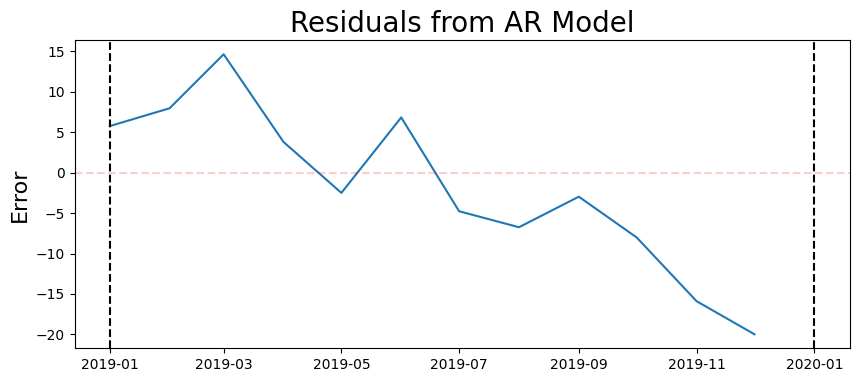

In [16]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--')

The residuals seem to be centered around zero, but there is clear decreasing pattern here, this is something that we do not anticipate. So there must be something in the model/data that we did not capture

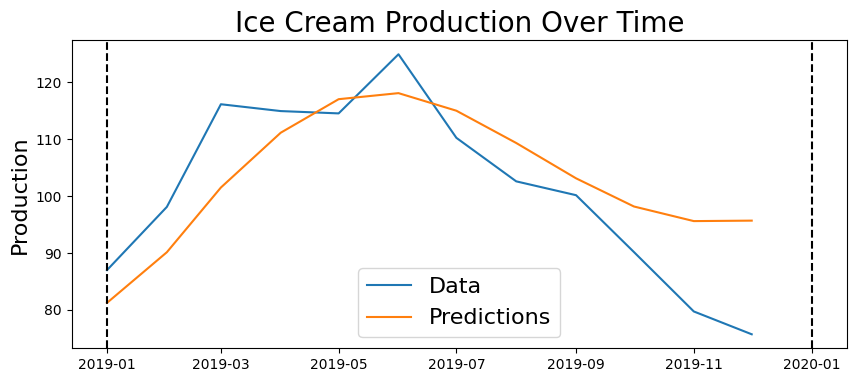

In [17]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production Over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2019, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--')

In [18]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0895


In [19]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 9.88415875183317


# Rolling Forecast Origin

In [20]:
train_end = datetime(2016, 12, 1)
test_end = datetime(2019, 12, 1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[
    train_end + timedelta(days=1):test_end]


In [21]:
predictions_rolling = pd.Series()
for end_date in test_data.index:
    # note: we are not using precited data as input, but the original data itself
    train_data = production_ice_cream[:end_date - timedelta(days=1)]
    model = ARIMA(train_data, order=(3,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]
    

In [22]:
residuals_rolling = test_data - predictions_rolling

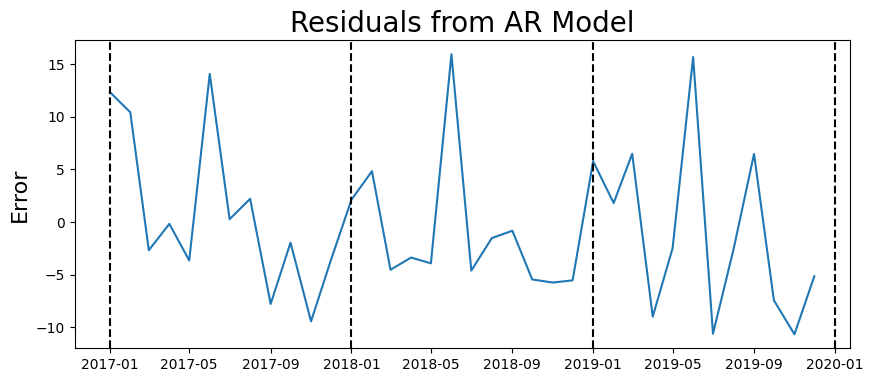

In [23]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)

plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
for year in range(2017, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--')

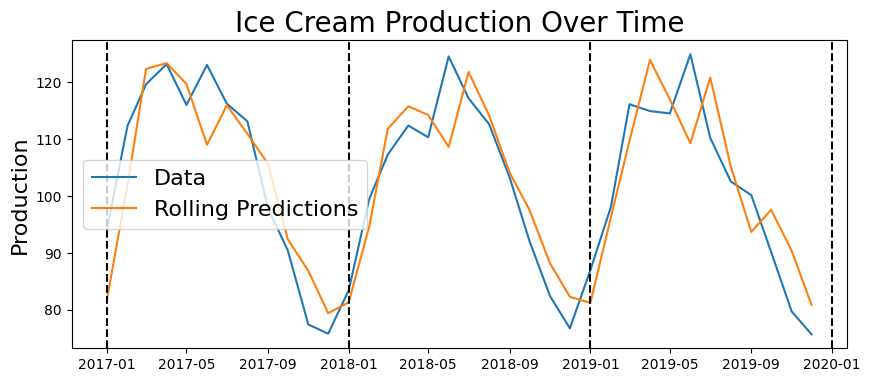

In [24]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions_rolling)

plt.legend(('Data', 'Rolling Predictions'), fontsize=16)

plt.title('Ice Cream Production Over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2017, 2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--')